In [190]:
import numpy as np
from collections.abc import Iterable
import numbers
import jax.numpy as jnp
from jax import grad
import plotly.graph_objects as go

In [208]:
class MLP_with_backpropagation():
    def identity(x):
        return x
        
    def __init__(self, shape, activations = None): #len(activations)+1=len(shape)
        fed_values = []
        activation_values = []
        for layer_size in shape:
            fed_values.append(np.array([0]*layer_size))
            activation_values.append(np.array([0]*layer_size))
        self.fed_values = fed_values
        self.activation_values = activation_values
        #first layer values are set so that indexes match
        weights = [0]
        biases = [0]
        for i in range(1, len(self.fed_values)):
            n = len(self.fed_values[i])
            m = len(self.fed_values[i-1])
            #initialising with random values
            weight_matrix = np.random.normal(0,1,(n,m))
            weights.append(weight_matrix)
            bias_vector = np.random.normal(0,1,n)
            biases.append(bias_vector)
        self.weights = weights
        self.biases = biases
        
        if activations:
            self.activations = [0] + [np.vectorize(activation) for activation in activations]
            self.activations_sv = [0] + [activation for activation in activations]
        else:
            self.activations = [0] + [np.vectorize(MLP_with_backpropagation.identity)] * (len(shape) - 1)
            self.activations_sv = [0] + [MLP_with_backpropagation.identity] * (len(shape) - 1)
            
    #2 functions below are only for technical purposes
    def is_iterable(obj):
        return isinstance(obj, Iterable)

    def is_numeric_vector_of_given_length(supposed_vector, length):
         if not MLP_with_backpropagation.is_iterable(supposed_vector):
             return False
         if len(supposed_vector) != length:
             return False
         for el in supposed_vector:
             if not isinstance(el, numbers.Number):
                 return False
         return True
        
    def set_input(self, inputt):
        if not MLP_with_backpropagation.is_numeric_vector_of_given_length(inputt, len(self.fed_values[0])):
            print("Wrong input size or type, it is supposed to be a numerical list or a 1D np.array of length of 1st layer")
            return False
        self.fed_values[0] = np.array(inputt)
        self.activation_values[0] = np.array(inputt) #input is input
        return True
        
    def feed_forward(self):
        for i in range(1, len(self.fed_values)):
            self.fed_values[i] = np.dot(self.weights[i], self.activation_values[i-1]) + self.biases[i] ##can do if statement if activation is function of layer not neuron
            self.activation_values[i] = self.activations[i](self.fed_values[i])

    def predict(self, x):
        if not self.set_input(x):
            return False
        self.feed_forward()
        return self.activation_values[-1]

    def predict_multiple(self, x):
        y = []
        for el in x:
            y.append(self.predict(el))
        return np.array(y)
        
    #manual setting of weights and biases    
    def set_weights(self, weights):
        self.weights = weights

    def set_biases(self, biases):
        self.biases = biases

    def squared_error(pred, expected):
        return (pred - expected)**2

    
    #returns a pair first element is for weights second for biases
    def derivative(self, inputt, expected):
        self.predict(inputt)
        dx = 10**(-6)
        weight_grad = [0] + [np.zeros(self.weights[i].shape) for i in range(1, len(self.weights))]
        bias_grad = [0] + [np.zeros(len(self.biases[i])) for i in range(1, len(self.biases))]
        neuron_activation_grad = [0] + [np.zeros(len(self.activation_values[i])) for i in range(1, len(self.activation_values))]
        neuron_fed_grad = [0] + [np.zeros(len(self.fed_values[i])) for i in range(1, len(self.fed_values))]
        last_layer = True
        for i in range(len(self.fed_values)-1, 0, -1):
            #derivatives in respect to neuron activation values
            for j in range(len(self.activation_values[i])):
                if last_layer:
                    x_0 = self.activation_values[i][j]
                    y_0 = expected[j]
                    dc_da = grad(MLP_with_backpropagation.squared_error, argnums = 0)
                    neuron_activation_grad[i][j] = dc_da(x_0, y_0)
                else:
                    neuron_activation_grad[i][j] = sum([neuron_fed_grad[i+1][k] * self.weights[i+1][k][j] for k in range(len(neuron_fed_grad[i+1]))])
                
                da_dz = grad(self.activations_sv[i], argnums = 0)                                       
                neuron_fed_grad[i][j] = neuron_activation_grad[i][j]*da_dz(self.fed_values[i][j])
                bias_grad[i][j] = neuron_fed_grad[i][j]
                
                for k in range(len(self.weights[i][j])):
                    weight_grad[i][j][k] = neuron_fed_grad[i][j] * self.activation_values[i-1][k]
            last_layer = False
        return (weight_grad, bias_grad)

    def add_2_lists_of_np_arrays(l1, l2):
        for i in range(len(l1)):
            l1[i] += l2[i]
        return l1
        
    def subtract_2_lists_of_np_arrays(l1, l2):
        for i in range(len(l1)):
            l1[i] -= l2[i]
        return l1
        
    def create_0filled_list_of_np_arrays(lista):
        listr = [0]
        for i in range(1, len(lista)):
            listr.append(np.zeros(lista[i].shape))
        return listr

    def multiply_list_elementwise(lista, factor):
        for i in range(len(lista)):
            lista[i] = lista[i] * factor
        return lista

    def learn(self, x, y, epochs, lr=0.01, batch_size = max(1,int(len(x)/100))):
            for i in range(epochs):
                idx = 0
                while(idx + batch_size < len(x)):
                    batchx = x[idx:idx+batch_size]
                    batchy = y[idx:idx+batch_size]
                    for i in range(batch_size):
                        local_weight_gradient, local_bias_gradient = self.derivative(batchx[i], batchy[i])
                        if i==0:
                            avg_weight_gradient = MLP_with_backpropagation.create_0filled_list_of_np_arrays(local_weight_gradient)
                            avg_bias_gradient = MLP_with_backpropagation.create_0filled_list_of_np_arrays(local_bias_gradient)
                        avg_weight_gradient = MLP_with_backpropagation.add_2_lists_of_np_arrays(avg_weight_gradient, local_weight_gradient)
                        avg_bias_gradient = MLP_with_backpropagation.add_2_lists_of_np_arrays(avg_bias_gradient, local_bias_gradient)
                    avg_weight_gradient = MLP_with_backpropagation.multiply_list_elementwise(avg_weight_gradient, 1/batch_size)
                    avg_bias_gradient = MLP_with_backpropagation.multiply_list_elementwise(avg_bias_gradient, 1/batch_size)
                    self.weights = MLP_with_backpropagation.subtract_2_lists_of_np_arrays(self.weights, MLP_with_backpropagation.multiply_list_elementwise(avg_weight_gradient, lr))
                    self.biases = MLP_with_backpropagation.subtract_2_lists_of_np_arrays(self.biases, MLP_with_backpropagation.multiply_list_elementwise(avg_bias_gradient, lr))
                    idx += batch_size
        

    
            
        

In [218]:
def MSE0_learn_MSE1(network, X_train, Y_train, X_test, Y_test):
    max_x = max(X_train)
    min_x = min(X_train)
    max_y = max(Y_train)
    min_y = min(Y_train)
    x_scl = max_x - min_x
    y_scl = max_y - min_y
    X_tr_scl = X_train / x_scl
    Y_tr_scl = Y_train / y_scl
    X_ts_scl = X_test / x_scl
    Y_ts_scl = Y_test / y_scl
    pred0 = network.predict_multiple(X_ts_scl.reshape(-1,1)) * y_scl
    MSE0 = sum((Y_test - pred0.reshape(-1))**2)
    network.learn(X_tr_scl.reshape(-1,1), Y_tr_scl.reshape(-1,1), 50, 2)
    pred1 = network.predict_multiple(X_ts_scl.reshape(-1,1)) * y_scl
    MSE1 = sum((Y_test - pred1.reshape(-1))**2)
    return MSE0, MSE1, pred0, pred1
    
network = MLP_with_backpropagation([1,5,1])
train = pd.read_csv("data/regression/square-simple-training.csv")
test = pd.read_csv("data/regression/square-simple-test.csv")

X_train = train['x'].values
Y_train = train['y'].values
X_test = test['x'].values
Y_test = test['y'].values
max_x = max(X_train)
min_x = min(X_train)
max_y = max(Y_train)
min_y = min(Y_train)
x_scl = max_x - min_x
y_scl = max_y - min_y
X_tr_scl = X_train / x_scl
Y_tr_scl = Y_train / y_scl
X_ts_scl = X_test / x_scl
Y_ts_scl = Y_test / y_scl

MSE0, MSE1, pred0, pred1 = MSE0_learn_MSE1(network, X_train, Y_train, X_test, Y_test)


    

In [219]:
MSE0

np.float64(265928750.63417447)

In [220]:
MSE1

np.float64(nan)

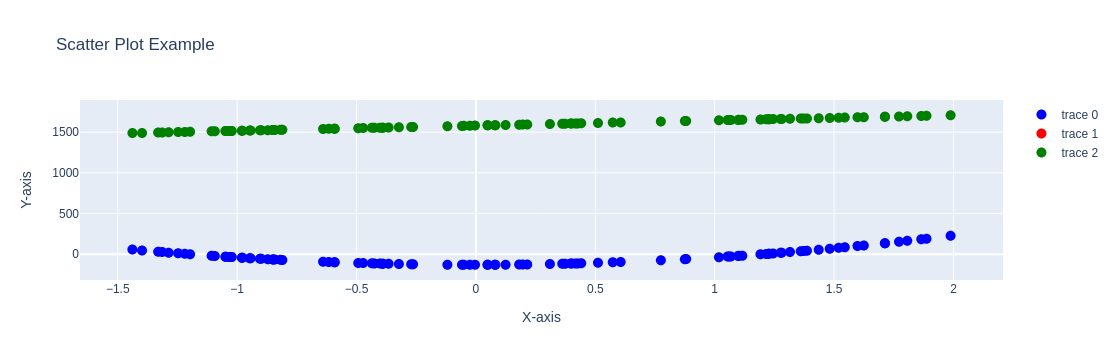

In [221]:
fig = go.Figure(data=go.Scatter(x=X_test, y=Y_test, mode='markers', marker=dict(color='blue', size=10)))

fig.add_trace(go.Scatter(x=X_test, y=pred1.reshape(-1), mode='markers', marker=dict(color='red', size=10)))
fig.add_trace(go.Scatter(x=X_test, y=pred0.reshape(-1), mode='markers', marker=dict(color='green', size=10)))

fig.update_layout(title="Scatter Plot Example", xaxis_title="X-axis", yaxis_title="Y-axis")

fig.show()

In [150]:
network = MLP_with_backpropagation([1,5,1])
network.derivative([2], [1])

[-0.47281368  2.6941238  -0.75494902 -1.11110316 -0.09680387] + [ 0.81893917 -0.58106128 -0.24249267 -0.56237396 -1.28480126]
[-1.50452024] + [-0.36423103]


([0,
  array([[-0.49614689],
         [ 4.84981966],
         [ 5.09489298],
         [-8.459342  ],
         [ 1.36545646]]),
  array([[ -1.9858959 , -12.12370167,   5.72282427,   9.60157933,
            7.92696302]])],
 [0,
  array([-0.24807344,  2.42490983,  2.54744649, -4.229671  ,  0.68272823]),
  array([-5.73750257])])

In [198]:
print(network.predict_multiple(X_test.reshape(-1,1)).reshape(-1))

[-0.48955938 -0.58603476 -0.0429638   0.40317287  0.33831056  0.45674669
 -0.45883217  0.63714048 -0.2841386  -0.4886744   0.3182897  -0.24103576
  0.40238238 -0.14148579  0.2605793   0.39815948 -0.43377799 -0.65845078
 -0.50757587  0.26280265  0.62313604  0.07932394  0.15187227 -0.4208658
  0.05773514 -0.44554103 -0.0602024  -0.25098665 -0.53522306 -0.43627808
  0.33293672 -0.11682143 -0.11374019 -0.01998394 -0.09471628 -0.50647706
  0.46728672  0.13848387  0.42443813  0.38854816  0.59941197  0.52098518
 -0.25109718 -0.33276143  0.35067523  0.357884    0.59919635  0.422732
 -0.5109494  -0.29245023 -0.42414618  0.40988153 -0.51725655 -0.51694933
 -0.59737055 -0.62442982  0.05297778 -0.54069392  0.35197879  0.33517998
  0.5528048   0.0320881   0.50584676 -0.07306476 -0.47621131 -0.0737321
  0.66970357 -0.013931   -0.34238622 -0.33215384  0.06732766  0.21994569
 -0.22358474 -0.61336442 -0.06101692  0.48720325  0.11348581 -0.19962761
  0.07498282  0.56355982 -0.00628645 -0.45675269  0.068